# Sentiment Analysis

This is the the 3rd notebook (out of 5) for <b>Project 3</b> of the GA Data Science Immersive<br>
Notebook by: <b>Martijn de Vries</b><br>
martijndevries91@gmail.com

## Problem Statement

A US political consultancy company is researching how news sources and discussed topics differ between the US political mainstream and the conservative right-wing media. In the last decade or so, the US political right-wing has been more and more described as living in an entirely separate information ecosystem from the political mainstream. In order to gauge how intense this effect is, we will collect, process, and classify the Reddit content of two politically-themed subreddit that reflect the mainstream and conservative voters respectively: <b>r/politics</b> and <b>r/conservative</b>. 

For this project, we will build two separate branches of models: one for post submissions (largely consisting of links to news sites), and another for comments (consisting of actual Reddit users discussing political news). As this is a binary classification problem where the two classes are of equal interest and will be approximately balanced, we will use the accuracy score as the main metric to gauge the success of the classification model. 

Because political news is always evolving, we have chosen a specific moment in time: the month leading up to the 2022 midterms, October 6th to November 6th 2022. This ensures that 1) the same news cycle is covered for both subreddits, 2) both subreddits were at peak activity, and 3) maximum potential for interesting insights in the way that news is discussed within these two subreddits.

## In this Notebook

I run a sentiment analysis using the roBERTa base model (imported through the transformers package) on the comments of the subreddits.

I'm keeping this step in a separate notebook because the necessary package, transformers, doesn't work in my default Python environment. So I've set up a separate conda environment for this package to work. 

The output is saved to a new csv in the data directory, all_comments_sentiment.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from transformers import pipeline

In [2]:
#Picking this model because it was trained on tweets, which seems somewhat similar to the short nature of many comments
sent = pipeline(model='cardiffnlp/twitter-roberta-base-sentiment')

For the sentiment analysis, I want to focus on comments as these are (primarily) text from actual people typing out things, rather than just news headlines.

In [10]:
com_df = pd.read_csv('../data/all_comments_cleaned.csv')
comments = com_df['body'].tolist()
print(len(comments))

47972


The sentiment analyzer is not super quick. Running through all 48000 comments is going to take a while..
Additionally, it seems that I get RuntimeErrors for long comments. So I'm adding a control flow statement that if the comment is too long (>1000 characters), I'm just cutting it off.

I'm also adding a try + except, because even with shorter comments there are a few comments with weird formatting that mess it up. I'll also make it write out to a csv every so often to save progress just in case.

Note, this step took about 4hrs to run on my macbook. I made it skippable - further below, in the 'Sentiment EDA' section, I load the CSV with sentiment labels and scores in t

In [4]:
def save_to_df(com_df, l1, l2):

    rows_to_add = com_df.shape[0] - len(l1)

    l1_to_save = l1 + [0] * rows_to_add
    l2_to_save = l2 + [0] * rows_to_add

    com_df['sent_label'] = l1_to_save
    com_df['sent_score'] = l2_to_save
    #Now that I have all sentiment labels and scores, commenting out this line to not accidentally overwrite
    #com_df.to_csv('../data/all_comments_sentiment.csv')
    return

In [5]:
sent_label, sent_score = [], []
for i in range(len(comments)):

    if i%500==0:print(i)
    comment = comments[i]
    if len(comment) > 1000:
        comment = comment[:1000]
    try:
        sentiment = sent(comment)
        sent_label.append(sentiment[0]['label'])
        sent_score.append(round(sentiment[0]['score'], 4))
    except: 
        sent_label.append(np.nan)
        sent_score.append(np.nan)
    if i%100==0:
        save_to_df(com_df, sent_label, sent_score)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500


In [11]:
#save full output (commented out to not overwrite my file by accident)
#com_df['sent_label'] = sent_label
#com_df['sent_score'] = sent_score
#com_df.to_csv('../data/all_comments_sentiment.csv')

### Sentiment EDA

Skip to this step to avoid running the full sentiment analysis. Let's load the new dataframe with sentiment scores

In [7]:
com_df = pd.read_csv('../data/all_comments_sentiment.csv')

How many NaN values did I get in the end?

In [9]:
com_df[['sent_label', 'sent_score']].isna().sum()

sent_label    0
sent_score    0
dtype: int64

Let's get rid of this one row

In [10]:
com_df.dropna(subset=['sent_label', 'sent_score'], inplace=True)
com_df[['sent_label', 'sent_score']].isna().sum()

sent_label    0
sent_score    0
dtype: int64

Great! Now let's do some EDA to see how predictive sentiments might be of which subreddit the comment comes from

In [11]:
#to normalize the number of posts under each label, for each subreddit
nl = com_df['subreddit'].value_counts().tolist()
norm_arr = np.array([nl[1]]*3 + [nl[0]]*3) 

In [12]:
print('Percentage of negative/neutral/positive (label 0/1/2) posts within each subreddit:')
com_df[['subreddit','sent_label']].groupby(by='subreddit').value_counts()/norm_arr

Percentage of negative/neutral/positive (label 0/1/2) posts within each subreddit:


subreddit     sent_label
conservative  LABEL_0       0.551885
              LABEL_1       0.365796
              LABEL_2       0.082319
politics      LABEL_0       0.595269
              LABEL_1       0.337018
              LABEL_2       0.067713
dtype: float64

There are some differences but they are not as big as I had hoped. The conservative subreddit has more neutral and positive sentiment comments (labels 1 and 2), while the politics subreddit has slightly more negative comments (label 0).
What if we look at score?

In [13]:
neg = com_df[com_df['sent_label'] == 'LABEL_0']
neutral =  com_df[com_df['sent_label'] == 'LABEL_1']
pos = com_df[com_df['sent_label'] == 'LABEL_2']

In [14]:
print('mean negative score')
display(neg[['subreddit','sent_score']].groupby(by='subreddit').mean())
print('-----')
print('mean neutral score')
display(neutral[['subreddit','sent_score']].groupby(by='subreddit').mean())
print('-----')
print('mean positive score')
display(pos[['subreddit','sent_score']].groupby(by='subreddit').mean())

mean negative score


,sent_score
subreddit,
conservative,0.749887
politics,0.756227


-----
mean neutral score


,sent_score
subreddit,
conservative,0.635265
politics,0.628790


-----
mean positive score


,sent_score
subreddit,
conservative,0.735867
politics,0.725943


That looks pretty similar. As a final check, I'll plot the distributions

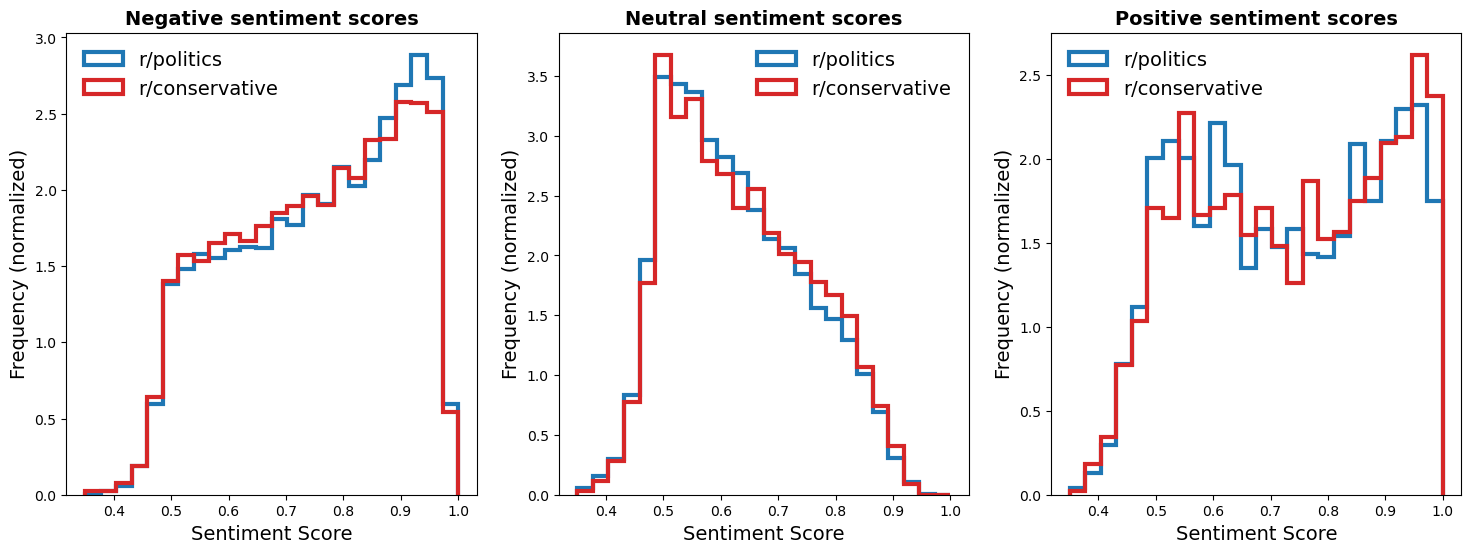

In [15]:
fig, axes = plt.subplots(1,3, figsize=(18, 6))
em_list = [neg, neutral, pos]
em_labels = ['Negative', 'Neutral', 'Positive']
linbins = np.linspace(0.35, 1, 25)
for i, em in enumerate(em_list):
    axes[i].hist(em[em['subreddit'] == 'politics']['sent_score'], bins=linbins, histtype='step', \
                 color='tab:blue', linewidth=3, density=True, label='r/politics')
    axes[i].hist(em[em['subreddit'] == 'conservative']['sent_score'], bins=linbins, histtype='step',\
                 color='tab:red', linewidth=3, density=True, label='r/conservative')
    axes[i].legend(numpoints=1, frameon=False, fontsize=14)
    axes[i].set_xlabel('Sentiment Score', fontsize=14)
    axes[i].set_ylabel('Frequency (normalized)', fontsize=14)
    axes[i].set_title(f'{em_labels[i]} sentiment scores', fontsize=14, fontweight='bold')
plt.show()

Those scores are so similar that I don't think it's worth including them. I will include the labels though (negative/neutral/positive).

In [16]:
#save to csv one more time to get rid of that one nan row
com_df.to_csv('../data/all_comments_sentiment.csv', index=False)